#Train script

###This script is used for training the models. It is divided into two parts: keras model (ANN) training and sklearn models (Ensemble models) training. All the auxiliary classes and functions can be found in package `itpma3_utils`<p> ANN model should be trained separately as the model is developed by Keras/TensorFlow, which has totaly different training configuring steps.

####The command below is to shift the interpreting environment to own personal Google Drive, please change to the correct path before run the command.

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/ITP_MA3_ProcessMonitoring

/content/drive/MyDrive/Colab Notebooks/ITP_MA3_ProcessMonitoring


###imports <p>
Here `keras.losses.BinaryFocalCrossentropy` might be helpful for the label imbalance resulted from data sampling.

In [ ]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from itpma3_utils.models import *
from itpma3_utils import *
import data_processing
from keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from keras.metrics import BinaryAccuracy
from keras.optimizers import Adam
from requirements import version_test

Function `version test()` is used for checking all the requirements and the versions of them. Whereas this does not work in Colab notebook for some reason. If the version of the library is more advanced than the requirements, this fine.

In [ ]:
# version_test(print_version=True)

Variables declaration

In [ ]:
batches = 32
epochs = 60
learning_rate = 0.001
input_shape = None
save_weights = True

####Dataset loading, include training set and validation set.<p>The data processing script has already processed the data simply, a further detailed processing includes feature selection, addition etc. should be done after the final conclusion of domain analysis and dataset analysis.

In [ ]:
x_train, x_val, y_train, y_val = data_processing.load_process()
for datas in [x_train, x_val, y_train, y_val]:
  print(datas.shape, end=" ")
print(" ")

Hello MA3
['cube ID', 'X', 'Y', 'Z', 'border_label', 'sintering_duration_sum', 'sintering_duration_sum.1', 'senor1_mean', 'senor2_mean', 'senor3_mean', 'sensor1_var', 'sensor2_var', 'sensor3_var', 'sensor1_skew', 'sensor2_skew', 'sensor3_skew', 'mean_scanspeed', 'mean_hacthspacing', 'mean_energydensity', 'var_scanspeed', 'var_hatchspacing', 'var_energydensity']
(4733, 22) (4733,)
(3786, 22) (947, 22) (3786,) (947,)  


####Instantiate a model<p>
As mentioned, the first model is artificial neural network (also called multi-layer perceptron, fully connected network). This model is developed using Keras, which is an Advanced API based on TensorFlow

#####Arguments:<p>
`input_shape`: input shape for a place holder<p>
`num_classes`: integer, number of target classes, which decides the final activation (softmax or sigmoid)<p>
`drop_rate`: float, range: $[0., 1.]$ dropout regularization, this is a linear method of drop out. for example, if the model has four layers and `drop_rate`=0.2, the dropout rate on each layer will be 0.05, 0.1, 0.15, 0.2 respectively.<p>
`layers`: integer or iterable, it decides both nunmber of hidden layers and number of units in each layer.<p>
`batch_norm`: boolean, whether add a batch normalization layer after each hidden layer or not, default: `False`<p>
`activation`: str or any, activation function for each unit. default: 'relu'

In [ ]:
model = MultiLayerPerceptron(x_train.shape, num_classes=2, drop_rate=0.25, layers=(64, 32), )

####Learning rate scheduler<p>
To reduce the oscillation of the model when approaching the global minimum (loss), learning rate decay can be used for reducing the steps for each iteration.<p>
Here are some choices in class `LearningRateSchedulers` (which can be dound in our util package): linear decay, exponential decay and cosine decay. In this model, linear decay is recommend as the decay rate is even.

In [ ]:
lr_scheduler = LearningRateScheduler(
        LearningRateSchedulers(epochs, step=10, init_lr=learning_rate).linear_scheduler)

####Definition of loss function, optimizer and metric<p>
Here the loss function is binary cross entropy for binary classfication. Adam optimizer used for reduce the oscillation for each mini-batch and speed up to convergence. 

In [ ]:
model.compile(
        loss=BinaryCrossentropy(),
        optimizer=Adam(learning_rate=learning_rate),
        metrics=BinaryAccuracy()
    )

###Early Stopping and Weights Saving<p>
Early stopping is a general model regularization method, which stops iteration when accurcy or loss reach the optimal.<p> `ModelCheckpoint` class is used for monitoring the whole training process and save the best performance from the epochs.

In [ ]:
checkpoint = ModelCheckpoint(filepath=f'./checkpoint/{model.name}_weights.h5',
                                 monitor='val_binary_accuracy',
                                 save_best_only=True, save_weights_only=save_weights, mode='auto')

####Train the model<p>
please do not run this line repeatedly as the parameters are not reset. Rerun will continue training from the last training session.

In [ ]:
history = model.fit(x_train, y_train, batch_size=batches, epochs=epochs, validation_data=(x_val, y_val),
                        callbacks=[lr_scheduler, checkpoint])

Epoch 1/60
119/119 [==============================] - 5s 8ms/step - loss: 0.5894 - binary_accuracy: 0.6957 - val_loss: 0.5069 - val_binary_accuracy: 0.7698 - lr: 0.0010
Epoch 2/60
119/119 [==============================] - 0s 4ms/step - loss: 0.4815 - binary_accuracy: 0.7697 - val_loss: 0.4568 - val_binary_accuracy: 0.7920 - lr: 0.0010
Epoch 3/60
119/119 [==============================] - 0s 4ms/step - loss: 0.4331 - binary_accuracy: 0.7990 - val_loss: 0.4285 - val_binary_accuracy: 0.8089 - lr: 0.0010
Epoch 4/60
119/119 [==============================] - 0s 4ms/step - loss: 0.4004 - binary_accuracy: 0.8228 - val_loss: 0.4163 - val_binary_accuracy: 0.8110 - lr: 0.0010
Epoch 5/60
119/119 [==============================] - 0s 4ms/step - loss: 0.3785 - binary_accuracy: 0.8320 - val_loss: 0.4013 - val_binary_accuracy: 0.8258 - lr: 0.0010
Epoch 6/60
119/119 [==============================] - 1s 4ms/step - loss: 0.3593 - binary_accuracy: 0.8494 - val_loss: 0.3856 - val_binary_accuracy: 0.8427

####Simple evaluation
A more detailed evaluation can be seen in script `evaluate.ipynb`

In [ ]:
train_loss, train_acc = model.evaluate(x_train, y_train)
val_loss, val_acc = model.evaluate(x_val, y_val)

print(f"model train loss: {train_loss}, train accuracy: {train_acc}")
print(f"model test loss: {val_loss}, test accuracy: {val_acc}")

30/30 [==============================] - 0s 3ms/step - loss: 0.3629 - binary_accuracy: 0.8902
model train loss: 0.11879836022853851, train accuracy: 0.9587955474853516
model test loss: 0.3628545105457306, test accuracy: 0.8901795148849487


###Plot model loss and accuracy curves

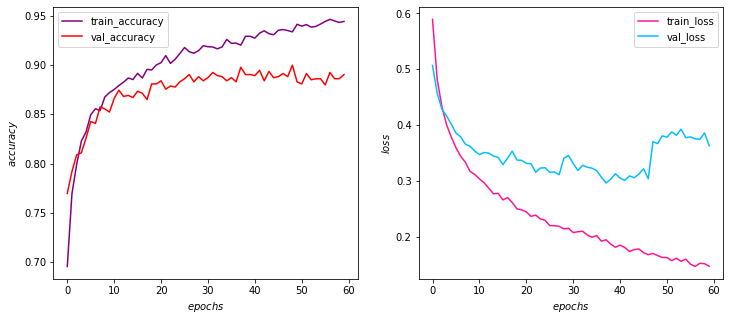

In [ ]:
# plot loss and accuracy curves
plot_model_curve(history)

The weights of the model has been stored, a more detailed evaluation can be seen in script `evaluate.ipynb`

The rest model will be instantiated and trained later on.